# Рубежный контроль №2
Турусов Владислав, ИУ5-64, Вариант №15, Задача №1

# Задание
Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

Необходимо сформировать признаки на основе CountVectorizer или TfidfVectorizer.

В качестве классификаторов необходимо использовать два классификатора, не относящихся к наивным Байесовским методам (например, LogisticRegression, LinearSVC), а также Multinomial Naive Bayes (MNB), Complement Naive Bayes (CNB), Bernoulli Naive Bayes.

Для каждого метода необходимо оценить качество классификации с помощью хотя бы одной метрики качества классификации (например, Accuracy).

Сделате выводы о том, какой классификатор осуществляет более качественную классификацию на Вашем наборе данных.

# Решение

Подключим необходимые библиотеки и загрузим набор данных

In [2]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

### Очистим набор данных
Уберем знаки хэштэга(#), но оставим сами тэги

In [3]:
input_file = codecs.open("socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

Удалим URL-адреса, и превратим все слова в строчные

In [4]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [5]:
questions.tail()

,text,choose_one,class_label
10854,1.3 #Earthquake in 9Km Ssw Of Anza California ...,Relevant,1
10855,Evacuation order lifted for town of Roosevelt:...,Relevant,1
10856,See the 16yr old PKK suicide bomber who detona...,Relevant,1
10857,To conference attendees! The blue line from th...,Relevant,1
10858,The death toll in a #IS-suicide car bombing on...,Relevant,1


In [6]:
questions.describe()

,class_label
count,10859.000000
mean,0.431808
std,0.498317
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


Используем регулярные выражения для очистки данных

In [7]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [8]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10854,10854,1 3 earthquake in 9km ssw of anza california ...,Relevant,1
10855,10855,evacuation order lifted for town of roosevelt,Relevant,1
10856,10856,see the 16yr old pkk suicide bomber who detona...,Relevant,1
10857,10857,to conference attendees! the blue line from th...,Relevant,1
10858,10858,the death toll in a is suicide car bombing on...,Relevant,1


Проверим баланс классов

In [9]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6186,6186,6186
1,4657,4657,4657
2,16,16,16


Как видно, что наши классы довольно сбалансированы, с небольшой избыточной выборкой класса «Неактуальный».

# Данные очищены, теперь их нужно подготовить
Теперь, когда наши входные данные более разумны, давайте преобразуем наши входные данные так, чтобы наша модель могла их понять. Из этого следует:
- Токенизация предложений в список отдельных слов
- Создание тестового сплита

In [10]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


### Углубленный осмотр данных

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154484 words total, with a vocabulary size of 18095
Max sentence length is 34


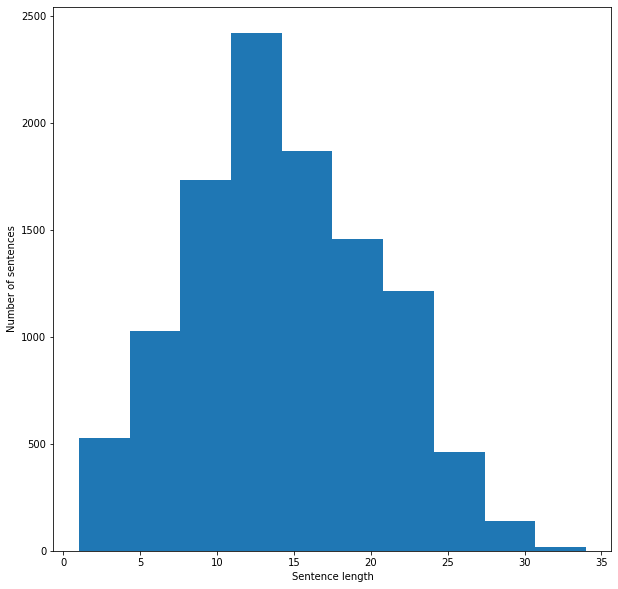

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

Самый простой подход, с которого мы можем начать, это использовать модель пакета слов и применить логистическую регрессию сверху. Мешок слов просто связывает индекс с каждым словом в нашем словаре и встраивает каждое предложение в виде списка 0, где 1 в каждом индексе соответствует слову, присутствующему в предложении.

## Сумма слов имеет значение

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = TfidfVectorizer()

    emb = count_vectorizer.fit(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)
X_train_counts = count_vectorizer.transform(X_train)
X_train_counts

<8687x15928 sparse matrix of type '<class 'numpy.float64'>'
	with 109257 stored elements in Compressed Sparse Row format>

### Визуализация вложений
Теперь, когда мы создали вложения, давайте представим их и посмотрим, сможем ли мы определить какую-то структуру. В идеальном мире наши вложения были бы настолько различны, что два класса были бы идеально разделены. Поскольку визуализация данных в измерениях размером 20 Кб является сложной, давайте спроецируем их до 2.

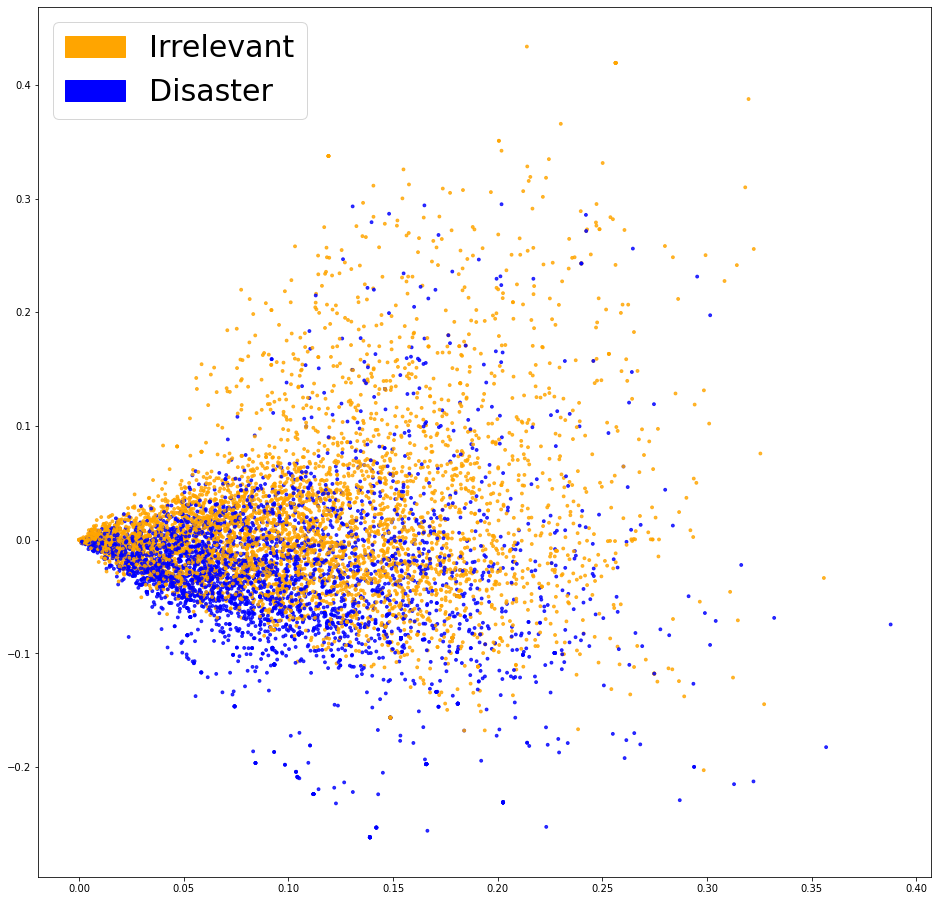

In [14]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [15]:
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('clf', MultinomialNB()),
])

In [21]:
def test(text_clf):
    print(text_clf)
    text_clf.fit(X_train_counts, y_train)
    print("accuracy:", accuracy_score(y_test, text_clf.predict(X_test_counts)))

In [22]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

In [24]:
test(MultinomialNB())

MultinomialNB()
accuracy: 0.7868324125230203


In [25]:
test(LinearSVC())

LinearSVC()
accuracy: 0.7730202578268877


In [26]:
test(ComplementNB())

ComplementNB()
accuracy: 0.7767034990791897


In [27]:
test(BernoulliNB())

BernoulliNB()
accuracy: 0.7914364640883977


#### Вывод

Метод Bernouilli Naive Bayes, лучше всего решает поставленную задачу многоклассовой классификации в условиях дисбаланса классов, MultinominalNB также показал отличный результат и практический не уступил методу Complement Naive Bayes. Остальные методы так же показали близкую точность